# amLDS: example on synthetic data

This notebook is a walk through the use of amLDS for estimating shared latent dynamics and stimulus decoding using synthetic "neural" data. <br> <br>
1) we simulate a shared stimulus-specific latent neural responses according to the generative model <br>
2) we generate the associated animal-specific high-dimensional measurements <br>
3) we estimate the shared manifold, amLDS parameters, by EM using data from several animals <br>
4) we estimate latents from unseen observations (test dataset) <br>
5) we provide probabilistic estimate of the decoded stimulus identity via hierarchical inference  <br>

Lastly, we estimate the latent dimensionality using the marginal likelihood and the reconstruction error for model comparison. Note that this should be the first step when using amLDS on data. <br>

amLDS assumes that stimuli are encoded in the coordinated activity of populations of neurons, and this responses are shared across animals (Fig.A). The generative model si shown in Fig. B.

![fig.png](funs/figs.png)

## Import relevant modules and amLDS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2
from funs.amLDS_engine import amLDS as amLDSm
from funs.amLDS_utils  import *

## Define ground truth amLDS parameters and hyperparameters

The model hyperparameters are include the number of animals/subjects, stimuli and latent and observed dimensions. The assumption of amLDS generative model is that the latent dynamics are stimulus-specific and shared across animals. This forces the dimensionality of the latent manifold to be unique, however it allows for different obseration dimensions per animal. 

The model parameters can be divided in two: parameters driven the latent dynamics (**A**, **Q**, **b** and **Q0** ; which are stimulus specific but shared across animals), and parameters mapping the observed measurments (**C**, **R**; which are animal specific but shared across stimuli).

In [3]:
nStim   = 50; nSbj = 5
sbjIDs  = ['sbj'+str(i)  for i in range(nSbj)]  
stimIDs = ['stim'+str(i) for i in range(nStim)]

zdim = 3                                     # same for all subjects and stimuli
xdim = {key: 40 for key in sbjIDs}           # subject specific ; could be different for different subjects
timepoints = 41                              # number of time steps ; it could vary on a trial by trial basis
trialN = 50                                  # number of trials per stimulus condition and subject ; could vary

In [4]:
np.random.seed(10)
# simulate latent parameters (stimulus specific) 
true_A_  = {key: A_init(zdim)  for key in stimIDs}
true_Q_  = {key: Q_init(zdim)  for key in stimIDs}
true_Q0_ = {key: Q_init(zdim)  for key in stimIDs}
true_x0_ = {key: x0_init(zdim) for key in stimIDs}
true_b_  = bs_init3D(stimIDs)

# simulate observation parameters (subject specific)
refC     = C_init(xdim[sbjIDs[0]], zdim)
true_C_  = {key: C_inits(refC)     for key in sbjIDs}
true_R_  = {key: R_init(xdim[key]) for key in sbjIDs}

## Sample latent trajectories and observed measuraments

In [5]:
idxx = 33 ; idxx_val = 1033                                   # set seeds for training and test sets
amLDSsample = amLDSm(zdim=zdim, sbjID=sbjIDs, stimID=stimIDs) # initialize model class

# sample from true latent parameters and structure observed data
XX = {} ; ZZ = {} ; XX_val = {}

for sbj in sbjIDs:
    CC = {} ; cc = {} ; CC_val = {}
    for stim in stimIDs:
        samples = []
        zamples = []
        for i in range(trialN):
            fooz, foox = amLDSsample.sample(A=true_A_[stim],   Q=true_Q_[stim], C=true_C_[sbj], R=true_R_[sbj], 
                                            x0=true_x0_[stim], b=true_b_[stim], timepoints= timepoints, seed=idxx)
            samples.append( foox )
            zamples.append( fooz )
            idxx +=1
        samples_val = []
        for i in range(int(10)): # number of validation trials
            samples_val.append(amLDSsample.sample(A=true_A_[stim], Q=true_Q_[stim],C=true_C_[sbj],R=true_R_[sbj], 
                                    x0=true_x0_[stim], b=true_b_[stim],timepoints= timepoints, seed=idxx_val)[1])
            idxx_val +=1
        CC[stim] = samples
        cc[stim] = zamples
        CC_val[stim] = samples_val
    XX[sbj] = CC
    ZZ[sbj] = cc
    XX_val[sbj] = CC_val

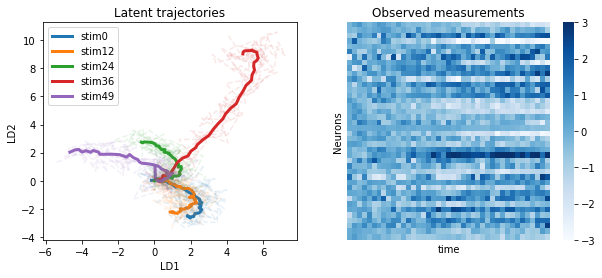

In [6]:
plot_LatentsObserveds(ZZ, sbjIDs[-1], stimIDs, XX, sbjIDs[-1], stimIDs[0])

This are example latent space dynamics for the different stimuli (left; solid lines are averages over trials and dashed lines five example trials); and an example trial for a given animal (right).

## amLDS parameter learning and decoding

In [7]:
amLDS = amLDSm(zdim=zdim, sbjID=sbjIDs, stimID=stimIDs, timepoints=timepoints)  # initialize model class
amLDS.import_data(data=dict(XX))                                                # import data
amLDS.import_validationData(data=dict(XX_val))                                  # import validation data
amLDS.init_params(xdim=xdim[sbjIDs[0]], TL_FAinit=True, AQ_init=True)           # initialize parameters
amLDS.LDS_EM_TranferLearning();                                                 # EM parameter learning

Initializating C and R using population factor analysis
Initializating b using latent estimates
Initializating A and Q using latent estimates
Learning amLDS parameters via EM


In [8]:
zz_amLDS = {}                                                                    # infere latents
for sbj in sbjIDs:
    zz_amLDS[sbj] = {stim: amLDS.getLatents(XX=None, sbj=sbj, stim=stim) for stim in stimIDs}

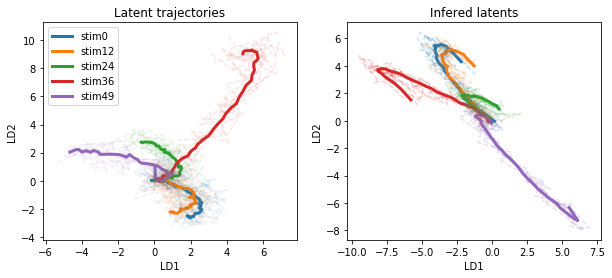

In [9]:
plot_LatentsLatents(ZZ, sbjIDs[-1], stimIDs, zz_amLDS)                           # latents visualization 

Comparison between simulated and recostructed trajectories. Note that there could be degeneracies on the latent space alignment.

Decoding stimulus class


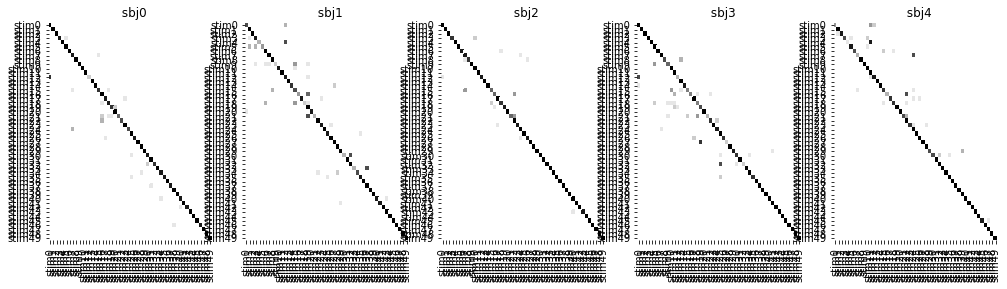

In [10]:
amLDS.probability_decoding();                                                     # stimulus decoding
amLDS.visualize_performanceCM(amLDS.sbj_ProbCM, annott=False)                     # CM visualization

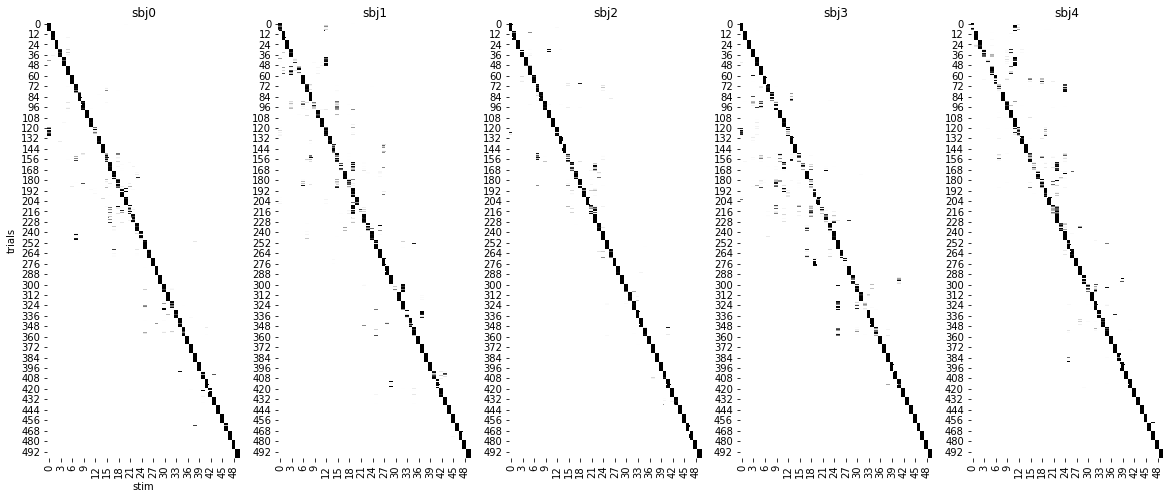

In [11]:
amLDS.visualize_Prstim()

Decoder performance visualization as the confusion matrix (top) and as probability of stimulus for each individual trial (bottom).

The decoder works accurately estimates even in a 50-label task. Change the model hyperparameters (e.g. increase the number of stimuli) to see the changes in performance.

## Parameter visualization

In addition to recovering the latent dynamics, inspection of the learnt amLDS parameters could help undertand the underlying computation.

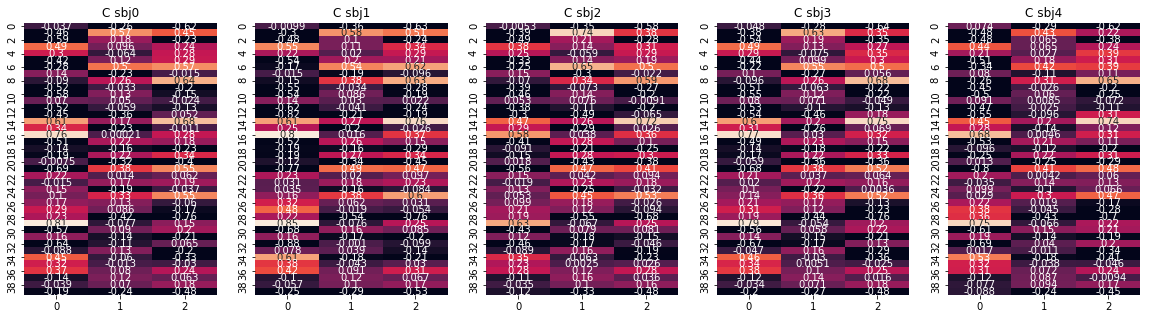

In [100]:
amLDS.visualize_params('C') # change the input to 'A', 'Q0', 'Q', 'C', 'R' or 'b' to visualize other params

# Estimate shared latent dimensionality

When using amLDS on data, one first needs to estimate the dimensionality of the shared latent space. In the previous example the dimensionality is known, but in a general case it has to be estimated from data by model comparison. Here, we provide two wasys to test the dimensionality, negative marginal likelhood and reconstruction error. Both estimate the quality of the fit in withheld data as a function of latent dimensionality.

In [61]:
# generate new data for testing
XX_test   = {}
idxx_test = 12
for sbj in sbjIDs:
    CC_test = {}
    for stim in stimIDs:
        samples_test = []
        for i in range(int(10)): # number of validation trials fro dimensionality estimation
            samples_test.append(amLDSsample.sample(A=true_A_[stim],Q=true_Q_[stim],C=true_C_[sbj],R=true_R_[sbj], 
                                    x0=true_x0_[stim], b=true_b_[stim],timepoints= timepoints, seed=idxx_test)[1])
            idxx_test +=1
        CC_test[stim] = samples_test
    XX_test[sbj] = CC_test

In [79]:
DIMS =  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15] # dimensions to check
LDS_err = []; LDS_LL = [];

for dd in DIMS:
    print('Latent dimensions '+str(dd))
    amLDSd = amLDSm(zdim=dd, sbjID=sbjIDs, stimID=stimIDs, timepoints=timepoints) # initialize model class
    amLDSd.import_data(data=dict(XX))                                             # import data
    amLDSd.init_params(xdim=xdim[sbjIDs[0]], TL_FAinit=True, AQ_init=True)        # initialize parameters 
    amLDSd.LDS_EM_TranferLearning();                                              # EM parameter learning
    LDS_err.append(amLDSd.reconstruction_error(XX_test))                          # estimate reconstruction error
    print('Reconstruction error for latent space dimension '+str(dd)+': '+str(np.mean(LDS_err[-1])))
    LDS_LL.append(amLDSd.marginal_loglikelihood(XX_test))                         # get posterior log-likelihood

Latent dimensions 1
Initializating C and R using population factor analysis
Initializating b using latent estimates
Initializating A and Q using latent estimates
Learning amLDS parameters via EM
Reconstruction error for latent space dimension 1: 0.7885670582351696
Latent dimensions 2
Initializating C and R using population factor analysis
Initializating b using latent estimates
Initializating A and Q using latent estimates
Learning amLDS parameters via EM
Reconstruction error for latent space dimension 2: 0.4688128257224105
Latent dimensions 3
Initializating C and R using population factor analysis
Initializating b using latent estimates
Initializating A and Q using latent estimates
Learning amLDS parameters via EM
Reconstruction error for latent space dimension 3: 0.39606924564765833
Latent dimensions 4
Initializating C and R using population factor analysis
Initializating b using latent estimates
Initializating A and Q using latent estimates
Learning amLDS parameters via EM
Reconstru

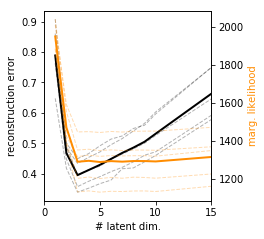

In [83]:
plot_estimatedLatentDimensionality(LDS_err, LDS_LL, DIMS, sbjIDs)

The dimensionality of the shared manifold is the dimension for which the reconstration error and negative log likelihood of the marginal are minimal.